<a href="https://colab.research.google.com/github/stswee/IntroCompStatsHSSP2023/blob/main/Class_Code/Intro_to_Comp_Statistics_Day_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Computational Statistics (HSSP 2023 Edition)
## Day 4: Bootstrapping and Data Analysis

In this notebook, we will run bootstrapping programs and perform basic data analysis.

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from scipy.stats import norm
from scipy.stats import chi2
import scipy.stats as stats
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Suppress warnings

### Activity 1: Rolling 2 Dice

Problem Statement:

You roll two four-sided dice and you want to see if there is a correlation between the rolls. You gather the following data:

In [ ]:
data = np.array([[15, 28, 30, 12], [22, 41, 10, 8], [30, 42, 28, 19], [31, 20, 10, 10]])
print(data)

[[15 28 30 12]
 [22 41 10  8]
 [30 42 28 19]
 [31 20 10 10]]


Each element can be thought of as a coordinate. For example, the 12 on the top right is (1, 4). This reflects the number of times we rolled 1 on the first dice and 4 on the second.

Compute the exact and estimated (bootstrap) p-value.

In [ ]:
# By hand calculations
# Initialize totals
row_total = np.zeros(data.shape[0])
column_total = np.zeros(data.shape[1])
sample_size = sum(sum(data))

for i in range(len(row_total)):
  row_total[i] = sum(data[i,:])

for j in range(len(column_total)):
  column_total[j] = sum(data[:, j])

print(sample_size)

# Alternatively, for column total, can use the code below
# column_total = sum(data)

# Determine expected counts array
expected_counts = np.zeros(data.shape)

for i in range(len(row_total)):
  for j in range(len(column_total)):
    expected_counts[i, j] = row_total[i] * column_total[j] / sample_size

# Calculate chi-square test statistic
test_statistic = 0
for i in range(data.shape[0]):
  for j in range(data.shape[1]):
    test_statistic += (data[i, j] - expected_counts[i,j])**2 / (expected_counts[i, j])

# Determine degrees of freedom
df = (data.shape[0] - 1) * (data.shape[1] - 1)

# Determine p-value
pval = 1 - chi2.cdf(test_statistic, df, loc=0, scale=1)

print('Test statistic is : ' + str(test_statistic))
print('p value : ' + str(pval))

356
Test statistic is : 29.801693601015938
p value : 0.00047413494743742124


In [ ]:
# Using stats package
test_statistic, pval = stats.chi2_contingency(data)[0:2]
print('Test statistic is : ' + str(test_statistic))
print('p value : ' + str(pval))

Test statistic is : 29.801693601015945
p value : 0.000474134947437475


In [ ]:
# Bootstrap
# Initialize totals
row_total = np.zeros(data.shape[0])
column_total = np.zeros(data.shape[1])
sample_size = sum(sum(data))

for i in range(len(row_total)):
  row_total[i] = sum(data[i,:])

for j in range(len(column_total)):
  column_total[j] = sum(data[:, j])

# Estimate null distribution
row_dist = row_total / sum(row_total)
column_dist = column_total / sum(column_total)

# Print null distribution
print(row_dist)
print(column_dist)

[0.23876404 0.22752809 0.33426966 0.1994382 ]
[0.2752809  0.36797753 0.21910112 0.13764045]


In [ ]:
# Function definition to draw from distribution
def draw_integers(integers, probabilities, n):
    random_integers = random.choices(integers, probabilities, k = n)
    return random_integers

In [ ]:
# Sample run
# Draw from estimated distribution
x = np.array(draw_integers([1, 2, 3, 4], row_dist, sample_size))
y = np.array(draw_integers([1, 2, 3, 4], column_dist, sample_size))

# Create contingency table
boot_contingency_table = np.histogram2d(x, y, bins=[np.max(x), np.max(y)])[0]
print("Contingency table:")
print(boot_contingency_table)
print()

# Calculate test statistic
boot_test_statistic = stats.chi2_contingency(boot_contingency_table)[0]
print("Test statistic:")
print(boot_test_statistic)
print()

Contingency table:
[[27. 36. 19.  8.]
 [28. 28. 19.  8.]
 [38. 52. 22.  8.]
 [19. 23. 13.  8.]]

Test statistic:
3.770037507218324



In [ ]:
# Run bootstrap
B = 10000 # Number of samples (for B = 10000, about 10-30 seconds)

# Storage for array of test statistics
boot_test_statistics = np.empty(B)

for b in range(B):
  # Draw from estimated null distribution
  x = np.array(draw_integers([1, 2, 3, 4], row_dist, sample_size))
  y = np.array(draw_integers([1, 2, 3, 4], column_dist, sample_size))

  # Get contingency table
  boot_contingency_table = np.histogram2d(x, y, bins=[np.max(x), np.max(y)])[0]

  # Calculate test statistic
  boot_test_statistic = stats.chi2_contingency(boot_contingency_table)[0]

  # Store test statistic
  boot_test_statistics[i] = boot_test_statistic

# Bootstrap p-value
pval = (sum(boot_test_statistics > test_statistic) + 1)/ (B + 1)
print(pval)

0.00019998000199980003


### Activity 2: Performing Data Analysis

Research Question: Is there a statistically significant association between gender, education level, and years of experience with salary?

Getting Dataset from Kaggle:

1. Sign in to Kaggle (make a free account if you have not already)

2. Go to https://www.kaggle.com/datasets/mohithsairamreddy/salary-data and download the dataset

3. Unzip the file and load dataset into Google Colab

In [ ]:
# Load in data
df = pd.read_csv("Salary_Data.csv")

# Rename columns
df = df.rename(columns = {"Education Level" : "Education", "Years of Experience" : "Experience"})

# Clean data
df = df.dropna()
df.loc[df['Education'] == "Bachelor's", 'Education'] = "Bachelor's Degree"
df.loc[df['Education'] == "Master's", 'Education'] = "Master's Degree"
df.loc[df['Education'] == "phD", 'Education'] = "PhD"

# Print unique values for categorical variables
print(df['Gender'].unique())
print(df['Education'].unique())

['Male' 'Female' 'Other']
["Bachelor's Degree" "Master's Degree" 'PhD' 'High School']


In [ ]:
# View first 5 rows of dataset
df.head()

,Age,Gender,Education,Job Title,Experience,Salary
0,32.0,Male,Bachelor's Degree,Software Engineer,5.0,90000.0
1,28.0,Female,Master's Degree,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's Degree,Sales Associate,7.0,60000.0
4,52.0,Male,Master's Degree,Director,20.0,200000.0


First, we will perform ordinary least-squares regression (similar to simple linear regression) using all of the datapoints. We will then calculate the confidence intervals for the slope.

In [ ]:
# Perform simple linear regression
ols_model = sm.ols(formula = 'Salary ~ Gender + Education + Experience', data = df)
results = ols_model.fit()

# Display results
print("Intercept: ", results.params[0])
print()
print("Gender Slope:\n", format(results.params[1:3]))
print()
print("Education Slope:\n", format(results.params[3:6]))
print()
print("Years Slope:\n", format(results.params[6]))
print()

Intercept:  60629.379757949806

Gender Slope:
 Gender[T.Male]     5451.391840
Gender[T.Other]     997.402955
dtype: float64

Education Slope:
 Education[T.High School]       -37213.319948
Education[T.Master's Degree]    11700.897463
Education[T.PhD]                21529.291806
dtype: float64

Years Slope:
 5750.2655933452



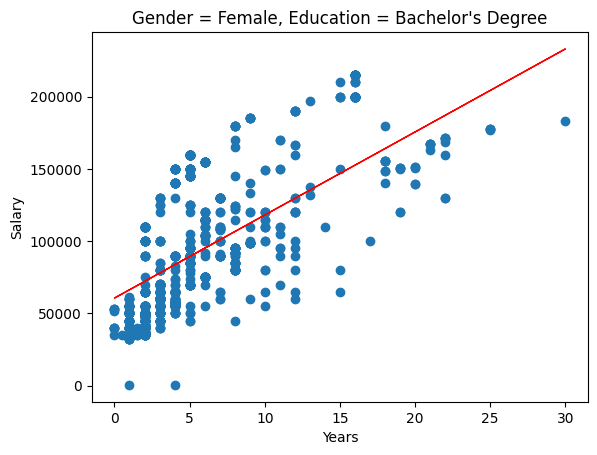

In [ ]:
# Plot
# Adjust these values
gender = "Female"
education = "Bachelor's Degree"

# Select actual values and make predictions
data = df[(df['Gender'] == gender) & (df["Education"] == education)]
x = data.iloc[:, :-1]
y_actual = data.iloc[:, -1]
y_pred = ols_model.fit().predict(x)

# Plot results
plt.scatter(x['Experience'], y_actual)
plt.plot(x['Experience'], y_pred, linewidth = 1, color = "red")
plt.xlabel("Years")
plt.ylabel("Salary")
plt.title("Gender = " + gender + ", Education = " + education)
plt.show()

In [ ]:
# Intercept and Slope 95% confidence intervals
results.conf_int(alpha = 0.05)

,0,1
Intercept,59138.837167,62119.922349
Gender[T.Male],4043.036286,6859.747394
Gender[T.Other],-14291.733559,16286.539469
Education[T.High School],-40136.222359,-34290.417537
Education[T.Master's Degree],9915.983675,13485.811250
Education[T.PhD],19336.860669,23721.722942
Experience,5606.628813,5893.902374


Next, we will use bootstrapping to sample a portion of the data and fit its respective slopes. Let's start with getting one sample.

In [ ]:
# Sample a portion of the dataset
sample = df.sample(n = df.shape[0], replace = True)

# Perform linear regression on sample
ols_model_boot = sm.ols(formula = 'Salary ~ Gender + Education + Experience', data = sample)
results_boot = ols_model_boot.fit()

# Display results
print("Intercept: ", results_boot.params[0])
print()
print("Gender Slope:\n", format(results_boot.params[1:3]))
print()
print("Education Slope:\n", format(results_boot.params[3:6]))
print()
print("Years Slope:\n", format(results_boot.params[6]))
print()

Intercept:  60652.631400356884

Gender Slope:
 Gender[T.Male]     4738.864566
Gender[T.Other]    1047.317632
dtype: float64

Education Slope:
 Education[T.High School]       -37136.392342
Education[T.Master's Degree]     9830.670374
Education[T.PhD]                21319.879083
dtype: float64

Years Slope:
 5877.892119896229



If you were to rerun the code above, you will get a different value every time. We can make the results reproducible by setting a seed. This is done by setting the random_state parameter to a particular value.

In [ ]:
# Sample a portion of the dataset
sample = df.sample(n = df.shape[0], replace = True, random_state = 0)

# Perform linear regression on sample
ols_model_boot = sm.ols(formula = 'Salary ~ Gender + Education + Experience', data = sample)
results_boot = ols_model_boot.fit()

# Display results
print("Intercept: ", results_boot.params[0])
print()
print("Gender Slope:\n", format(results_boot.params[1:3]))
print()
print("Education Slope:\n", format(results_boot.params[3:6]))
print()
print("Years Slope:\n", format(results_boot.params[6]))
print()

Intercept:  61071.84287163733

Gender Slope:
 Gender[T.Male]      5011.301627
Gender[T.Other]    12900.743734
dtype: float64

Education Slope:
 Education[T.High School]       -36998.728577
Education[T.Master's Degree]    11269.517985
Education[T.PhD]                20932.804604
dtype: float64

Years Slope:
 5742.689063526451



To generate the bootstrap 95% confidence interval and display a histogram of our results, we can first create an array to store the results. Then, we can sample from our dataset, perform a fit, and record the results. Finally, we can plot the results and compute the confidence interval.

In [ ]:
# Dataframe to store results
boot_results = pd.DataFrame({'Intercept' : [], 'Gender[T.Male]' : [], 'Gender[T.Other]' : [], 'Education[T.High School]' : [],
                             "Education[T.Master's Degree]" : [], 'Education[T.PhD]' : [], 'Experience' : []})

# Number of iterations
B = 1000 # (1000 takes about 45 seconds to run, 10000 about 6 minutes)

# Perform bootstrapping
for b in range(B):

  # Sample a portion of the dataset
  sample = df.sample(n = df.shape[0], replace = True, random_state = b) # Set random state to b for reproducibility

  # Perform linear regression on sample
  ols_model_boot = sm.ols(formula = 'Salary ~ Gender + Education + Experience', data = sample)
  results_boot = ols_model_boot.fit()

  # Append results
  boot_results = boot_results.append(results_boot.params[0:7], ignore_index = True)

  # Keep track of progress for every 100 iterations
  if (b % 100 == 0):
    print(b)

0
100
200
300
400
500
600
700
800
900


Text(0, 0.5, 'Frequency')

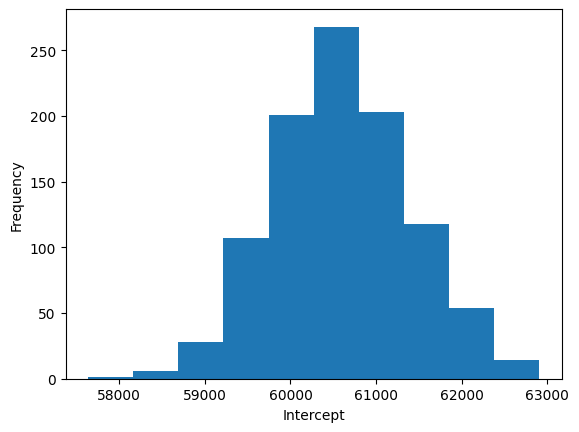

In [ ]:
# Basic histogram of intercept
plt.hist(boot_results.iloc[:,0])
plt.xlabel(boot_results.columns[0])
plt.ylabel("Frequency")

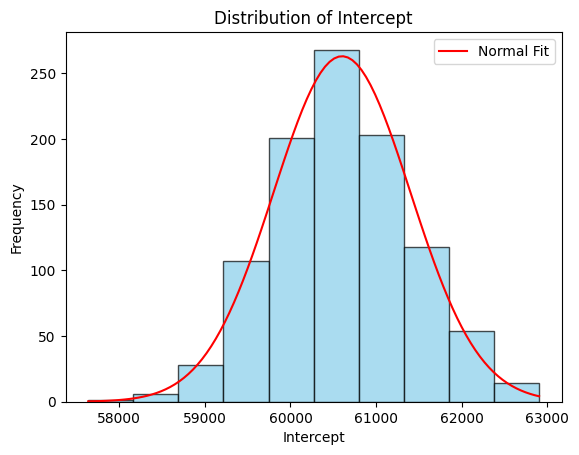

In [ ]:
# Code generated by ChatGPT
def plot_histogram_with_fit(data, num_bins=10, xlabel=None, ylabel=None, title=None):
    """
    Plots a histogram with a normal distribution fit overlay.

    Parameters:
        data (list or numpy array): The input data for the histogram and fit.
        num_bins (int): Number of bins for the histogram. Default is 10.
        xlabel (str): Label for the x-axis. Default is None.
        ylabel (str): Label for the y-axis. Default is None.
        title (str): Title for the plot. Default is None.

    Returns:
        None
    """
    # Create the histogram
    n, bins, patches = plt.hist(data, bins=num_bins, alpha=0.7, edgecolor='black', color='skyblue')

    # Get the mean and standard deviation of the data
    mean = np.mean(data)
    std = np.std(data)

    # Generate normal distribution data points for the overlay
    x = np.linspace(min(data), max(data), 100)
    y = norm.pdf(x, mean, std) * len(data) * (bins[1] - bins[0])  # Scaling to match the histogram

    # Plot the normal distribution fit
    plt.plot(x, y, 'r-', label='Normal Fit')

    # Set labels and title
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)

    # Show the plot with the legend
    plt.legend()
    plt.show()

plot_histogram_with_fit(boot_results.iloc[:,0], num_bins=10, xlabel=boot_results.columns[0], ylabel='Frequency', title='Distribution of ' + boot_results.columns[0])


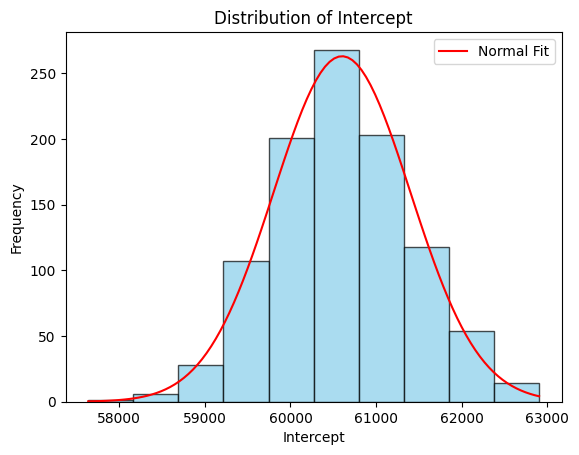

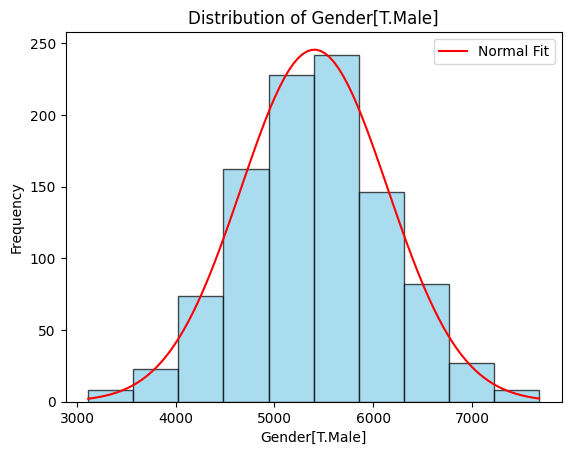

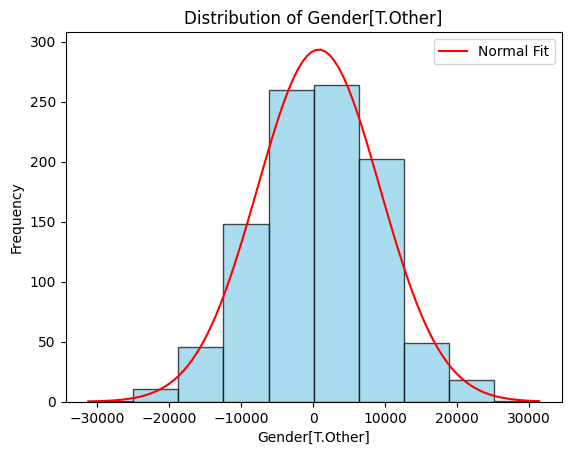

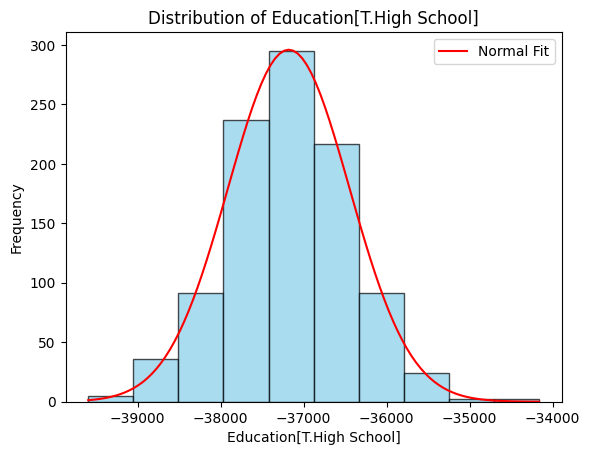

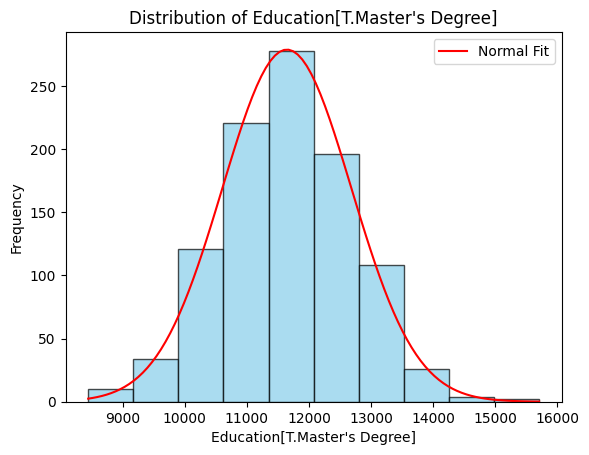

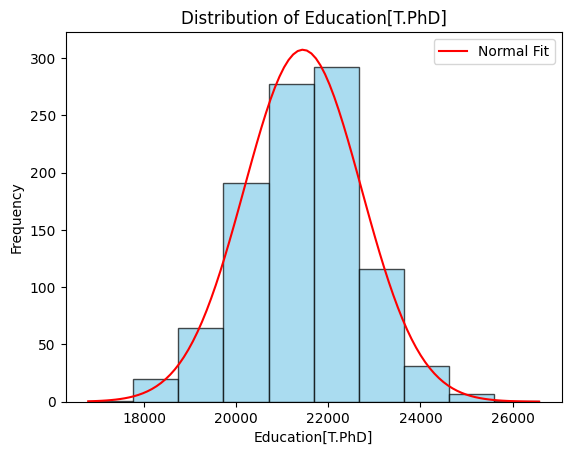

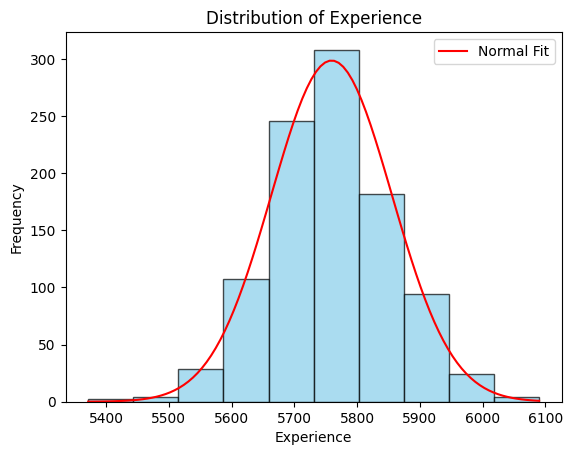

In [ ]:
# Plot all histograms
for i in range(boot_results.shape[1]):
  plot_histogram_with_fit(boot_results.iloc[:,i], num_bins=10, xlabel=boot_results.columns[i], ylabel='Frequency', title='Distribution of ' + boot_results.columns[i])


In [ ]:
# Generate confidence intervals
# Select significance level
alpha = 0.05

for i in range(boot_results.shape[1]):
  print(str(round(1 - alpha, 2)*100) + "% Confidence interval for " + str(boot_results.columns[i]) + ": [" +
  str(np.nanpercentile(boot_results.iloc[:,i], alpha/2 * 100)) + ", " +
  str(np.nanpercentile(boot_results.iloc[:,i], 100 - alpha/2 * 100)) + "]")

# Compare with original result
# Intercept and Slope 95% confidence intervals
results.conf_int(alpha)

95.0% Confidence interval for Intercept: [59122.25539895569, 62201.42457126855]
95.0% Confidence interval for Gender[T.Male]: [3958.0414328557845, 6819.402867739768]
95.0% Confidence interval for Gender[T.Other]: [-15726.35547641951, 17987.231713801197]
95.0% Confidence interval for Education[T.High School]: [-38656.434962619605, -35777.00029393798]
95.0% Confidence interval for Education[T.Master's Degree]: [9596.7898939405, 13623.482710392038]
95.0% Confidence interval for Education[T.PhD]: [18944.235815201235, 23897.27727920101]
95.0% Confidence interval for Experience: [5580.5422968755065, 5952.843626118046]


,0,1
Intercept,59138.837167,62119.922349
Gender[T.Male],4043.036286,6859.747394
Gender[T.Other],-14291.733559,16286.539469
Education[T.High School],-40136.222359,-34290.417537
Education[T.Master's Degree],9915.983675,13485.811250
Education[T.PhD],19336.860669,23721.722942
Experience,5606.628813,5893.902374
